In [1]:
import boto3
import awswrangler as wr

In [2]:
import pandas as pd

In [3]:
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")

In [4]:
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

In [5]:
df = wr.s3.read_parquet("s3://quant-bears-data-collection/raw-data/seekingAlphaBulkMetrics/2023-09-19.parquet", boto3_session=session)

In [6]:
df.head()

ticker  altman_z_score  analysts_down  analysts_down_percent  \
0     AA        1.401235            9.0             100.000000   
1    AAP        2.266178           14.0             100.000000   
2   ABCL        5.648530            1.0              14.285714   
3   ABCM        6.937922            1.0              25.000000   
4   ABEV        4.510405            2.0              66.666664   

   analysts_down_percent_avg_5y  analysts_up  analysts_up_percent  \
0                     60.255886          0.0             0.000000   
1                     38.802917          0.0             0.000000   
2                     39.515347          6.0            85.714290   
3                           NaN          3.0            75.000000   
4                     47.094288          1.0            33.333332   

   analysts_up_percent_avg_5y  assets_turnover  assets_turnover_avg_5y  ...  \
0                   39.744114         0.728491                0.758183  ...   
1                   61.197083         0.917976                0.930908  ...   
2                   60.484653         0.092735                0.414523  ...   
3                         NaN         0.363036                0.364674  ...   
4                   52.905710         0.612834                0.542864  ...   

     total_debt  total_revenue  working_cap_change  working_cap_change_avg_5y  \
0  1.834000e+09   1.086800e+10            -21.0507                  20.532969   
1  4.596040e+09   1.121875e+10             54.5253                 -10.475822   
2  8.403200e+07   1.451750e+08            -12.0268                2262.069600   
3  2.755801e+08   4.822016e+08             23.8888                  25.863136   
4  8.554309e+08   1.727274e+10            -95.3390                 116.744484   

   yld_on_cost_1y  yld_on_cost_1y_avg_5y  yld_on_cost_3y  \
0        0.942063                    NaN        3.003003   
1        2.847722               1.203241        3.086821   
2             NaN                    NaN             NaN   
3             NaN                    NaN             NaN   
4        5.098481               3.130066        6.037113   

   yld_on_cost_3y_avg_5y  yld_on_cost_5y  yld_on_cost_5y_avg_5y  
0                    NaN        0.927644                    NaN  
1               1.558655        2.833284               1.804696  
2                    NaN             NaN                    NaN  
3                    NaN             NaN                    NaN  
4               2.510408        3.164189               1.532657  

[5 rows x 265 columns]

In [57]:
int_df = df.select_dtypes(int)
float_df = df.select_dtypes(float)
float_df = float_df.fillna(0.)

In [103]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    return fig

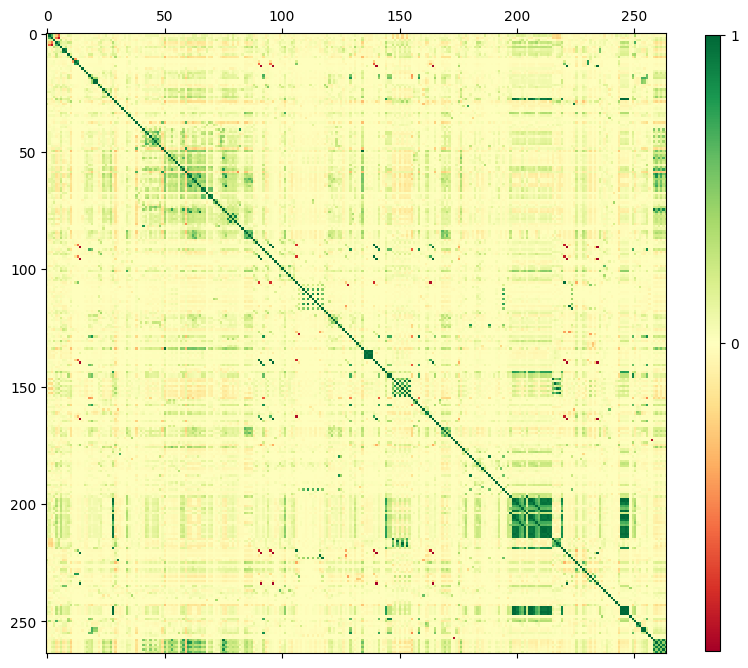

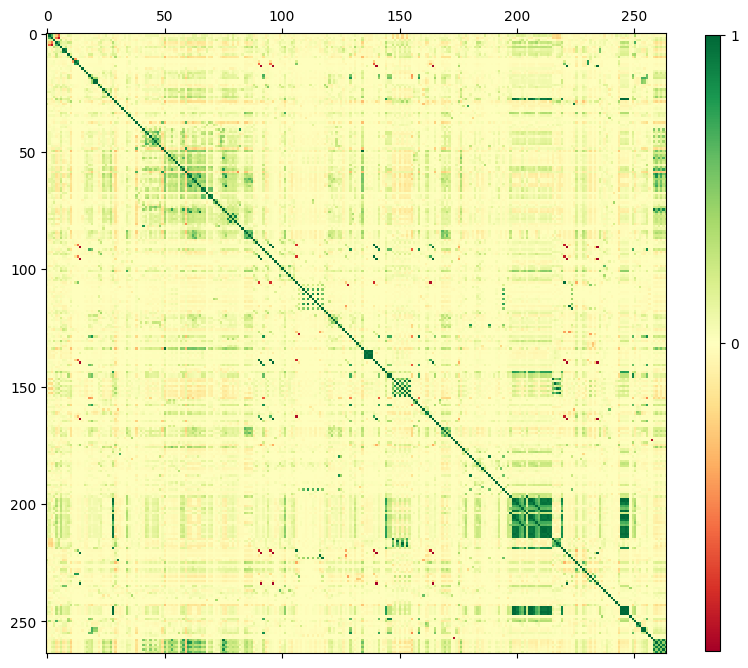

In [104]:
plot_corr(float_df)

In [17]:
# Source: https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb

import scipy
import numpy as np
import scipy.cluster.hierarchy as sch

float_df = float_df.fillna(0.)

X = float_df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [float_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
float_df = float_df.reindex(columns = columns)


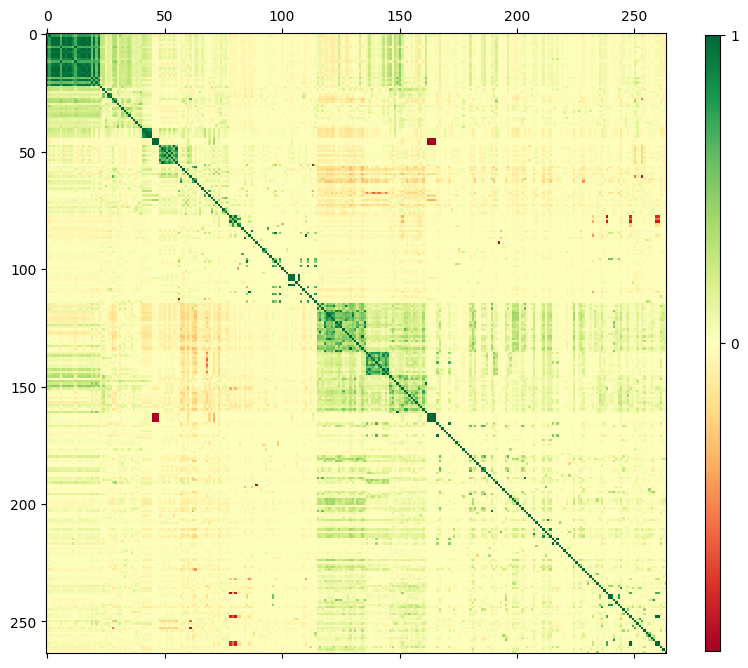

In [18]:
plot_corr(float_df)

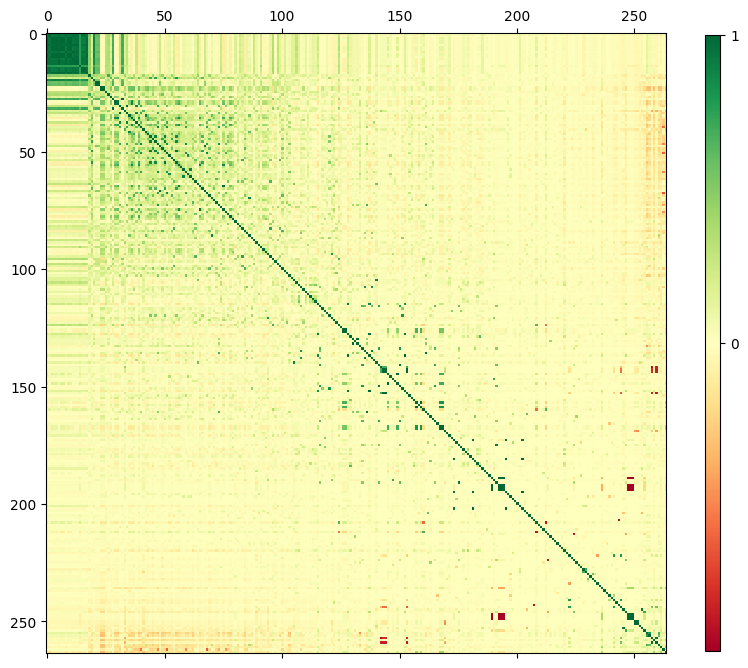

In [19]:
corr_values = float_df.corr()
cols = float_df.columns.tolist()
new_col_order = [x[0] for x in sorted(zip(cols, corr_values.sum(axis = 0).tolist()), key = lambda x: x[1], reverse=True)]

plot_corr(float_df[new_col_order])

In [21]:
# These features are all highly correlated
np.array(new_col_order)[:20]

array(['close', 'price_low_52w', 'sma_10d', 'price_close_1m',
       'price_close_adj_1m', 'sma_200d', 'price_close_1w',
       'price_close_adj_1w', 'price_close_ytd', 'sma_50d', 'sma_100d',
       'price_close_adj_ytd', 'price_close_6m', 'price_close_adj_6m',
       'log_of_unadjusted_stock_price', 'price_close_1y',
       'price_close_adj_1y', 'price_high_52w', 'eps_estimate',
       'div_rate_ttm'], dtype='<U61')

In [98]:
from sklearn.cluster import KMeans

In [99]:
kmeans = KMeans(n_clusters = 110)

In [100]:
labels_ = kmeans.fit_predict(float_df.T)

/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [101]:
clustered_col_order = []
for u in np.unique(labels_):
	clustered_col_order.extend(
		float_df.columns[labels_ == u].tolist()
	)

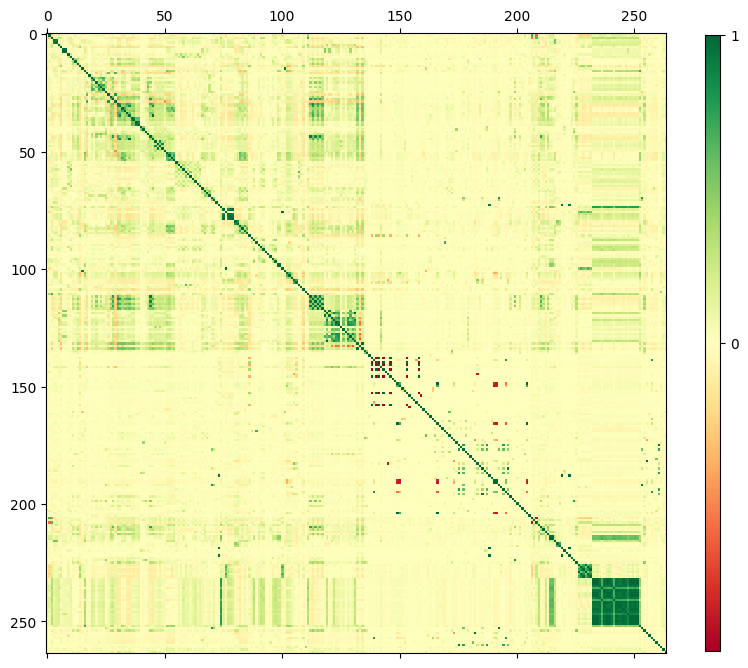

In [102]:
plot_corr(float_df[clustered_col_order])

In [131]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [132]:
def getKmeansClusteredCorrPlot(n_clusters, fig, ax):
	kmeans = KMeans(n_clusters = n_clusters)
	labels_ = kmeans.fit_predict(float_df.T)
	clustered_col_order = []
	for u in np.unique(labels_):
		clustered_col_order.extend(
			float_df.columns[labels_ == u].tolist()
		)
	return plot_corr_(float_df[clustered_col_order], fig, ax)
	

In [138]:
def plot_corr_(df, fig, ax):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    
    return fig

/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_52059/2263216531.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


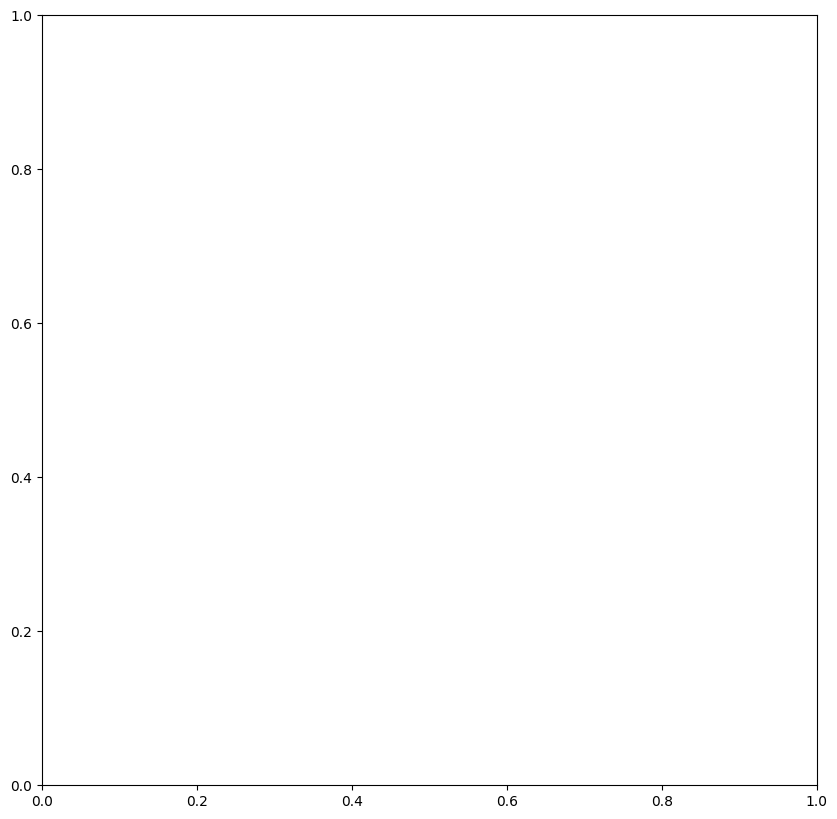

In [167]:

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

def init():
    pass

def update(frame):
    print(frame)
    return getKmeansClusteredCorrPlot(frame, fig, ax),

ani = FuncAnimation(fig, update, frames=range(50, 150, 5), interval=700,
                    init_func=init)
fig.show()

In [123]:
np.array(range(50, 150, 5))

array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145])

In [144]:
next(zip(np.array(range(50, 150, 5))))

(50,)

In [161]:
def animate(i, x=[], y=[]):
	plt.cla()
	x.append(i)
	y.append(np.random.randint(0, 10))
	plt.plot(x, y)

In [162]:
%matplotlib notebook
fig = plt.figure()
ani = FuncAnimation(fig, animate, interval=700)

<IPython.core.display.Javascript object>

/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_52059/4066905735.py:3: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, animate, interval=700)


50


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


50


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


55


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


60


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


65


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


70


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


75


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


80


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


85


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


90


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


95


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


105


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


110


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


115


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


120


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


125


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


130


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (129) found smaller than n_clusters (130). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


135


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (134) found smaller than n_clusters (135). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


140


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (138) found smaller than n_clusters (140). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


145


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (143) found smaller than n_clusters (145). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


50


/Users/nuowenlei/anaconda3/envs/QuantBearsDataAnalysis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


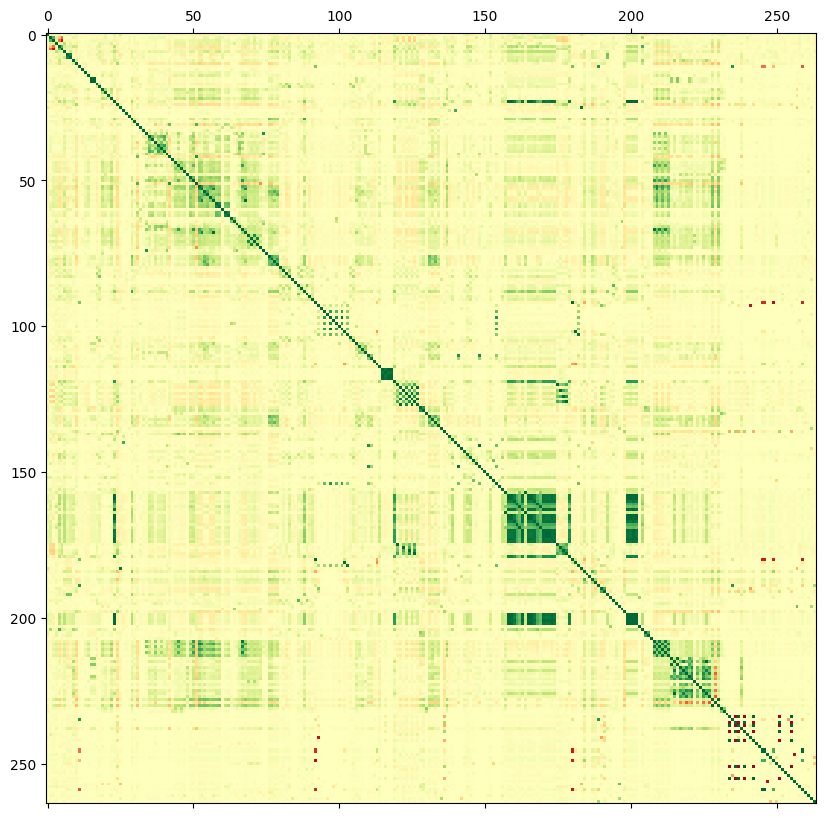

In [169]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

def animate(frame):
    print(frame)
    return getKmeansClusteredCorrPlot(frame, fig, ax),

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(50, 150, 5))

from IPython.display import HTML
HTML(ani.to_jshtml())

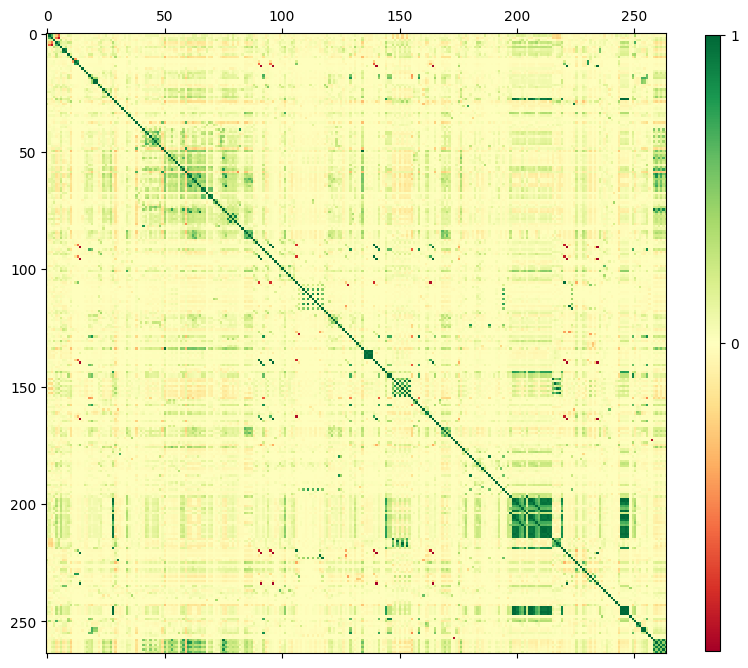

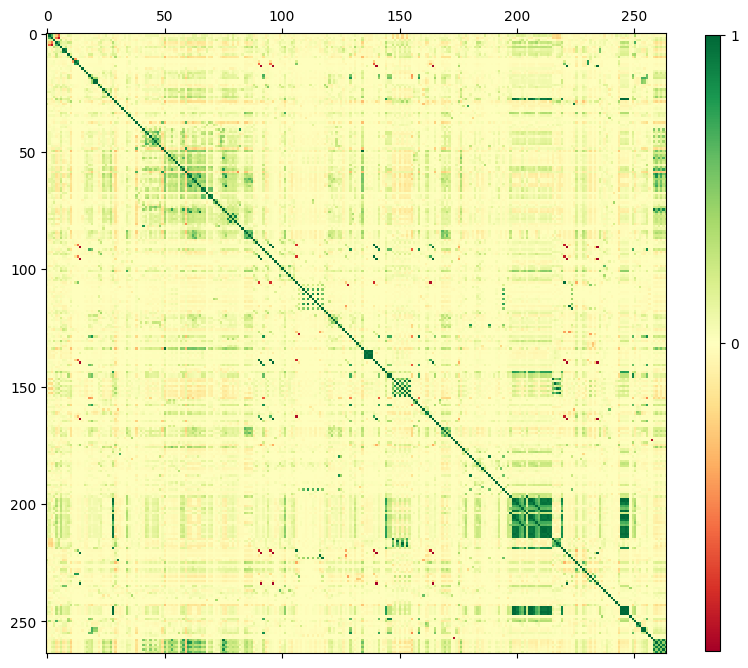

In [171]:
plot_corr(float_df)

In [172]:
float_df.columns

Index(['altman_z_score', 'analysts_down', 'analysts_down_percent',
       'analysts_down_percent_avg_5y', 'analysts_up', 'analysts_up_percent',
       'analysts_up_percent_avg_5y', 'assets_turnover',
       'assets_turnover_avg_5y', 'authors_count',
       ...
       'total_debt', 'total_revenue', 'working_cap_change',
       'working_cap_change_avg_5y', 'yld_on_cost_1y', 'yld_on_cost_1y_avg_5y',
       'yld_on_cost_3y', 'yld_on_cost_3y_avg_5y', 'yld_on_cost_5y',
       'yld_on_cost_5y_avg_5y'],
      dtype='object', length=264)